# Cross-matching of large catalogs: DES to Gaia

In this tutorial we cross-match tables of Dark Energy Survey (DES) DR2 and Gaia DR3 catalogs. The outline of the tutorial is as follows:

1. Get original data files
2. Convert the data to HATS format using [hats-import](https://github.com/astronomy-commons/hats-import/)
3. Cross-match the catalogs using LSDB and save to a new HATS catalog

## Introduction

This notebook shows a realistic crossmatching of two different survey datasets, starting at the original data files as hosted by their providers.

**DES DR2**

The Dark Energy Survey DR2 (DES DR2) catalog is hosted by NCSA, see the [official website](https://des.ncsa.illinois.edu/releases/dr2) for more information. Data files, in [FITS](https://fits.gsfc.nasa.gov) format, are located at <https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/>. You may also prefer to get the data with S3 client as described by <https://desdr-server.ncsa.illinois.edu>.

**Gaia DR3**

The Gaia DR3 catalog is hosted by ESA, see the [official website](https://www.cosmos.esa.int/web/gaia/dr3) for more information. Data files, in [ECSV](https://docs.astropy.org/en/stable/io/ascii/ecsv.html) format are located at <http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/>.

We use `gaia_source` table, see its [schema here](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html).

## 1. Install required packages and import modules

In [1]:
# Comment to skip hats-import installation
%pip install --quiet -U hats-import

# Uncomment to install lsdb
%pip install --quiet -U lsdb


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# For Gaia columns data types inference
from astropy.io import ascii

# We need this for 2D histogram
import dask.array

# Client for Dask distributed computing
from dask.distributed import Client

# For plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Numpy is always useful!
import numpy as np

# For files and directories manipulation
from upath import UPath

# Explore the HATS catalogs and plot sky maps
from hats import read_hats
from hats.inspection import plot_pixels

# For reading the HATS catalogs and performing the cross-match
import lsdb

# For converting the data to HATS format and generate margin caches
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

## 2. Get original data files

To make this notebook faster to run and using less storage, we will use a subset of the data. However, the same pipeline, with no code changes, may be used to process the full catalogs.

In [3]:
# Change to the directories where the data will be stored
DES_DIR = UPath("data/DES_DR2")
GAIA_DIR = UPath("data/Gaia_DR3")

GAIA_SCHEMA_FILE = GAIA_DIR / "schema.parquet"

DES_HATS_NAME = "des_dr2"
GAIA_HATS_NAME = "gaia_dr3"
GAIA_MARGIN_CACHE_NAME = "gaia_dr3_1arcsec"
XMATCH_NAME = "des_dr2_x_gaia_dr3"

HATS_DIR = UPath("catalogs")
DES_HATS_DIR = HATS_DIR / DES_HATS_NAME
GAIA_HATS_DIR = HATS_DIR / GAIA_HATS_NAME
GAIA_MARGIN_CACHE_DIR = HATS_DIR / GAIA_MARGIN_CACHE_NAME

XMATCH_DIR = HATS_DIR / XMATCH_NAME

### 2.1. DES DR2

The Dark Energy Survey DR2 catalog is hosted by NCSA, see the [official website](https://des.ncsa.illinois.edu/releases/dr2) for more information. Data files, in [FITS](https://fits.gsfc.nasa.gov) format, are located at <https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/>. You may also prefer to get the data with S3 client as described by <https://desdr-server.ncsa.illinois.edu>.

We use `*dr2_main.fits` files for the main catalog table; see [the schema here](https://des.ncsa.illinois.edu/releases/dr2/dr2-products/dr2-schema).

Here we download a few first files to demonstrate the pipeline. The full catalog is about 1.1TB--feel free to download it if you have enough storage.

In [4]:
# Comment / skip this cell if you already have the data

# Download few first files
des_urls = [
    UPath(
        "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/DES0000+0209_dr2_main.fits"
    ),
    UPath(
        "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0252/DES0000+0252_dr2_main.fits"
    ),
    UPath(
        "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0335/DES0000+0335_dr2_main.fits"
    ),
]

for des_url in des_urls:
    des_file = DES_DIR / des_url.name
    if not des_file.exists():
        des_file.parent.mkdir(parents=True, exist_ok=True)
        des_file.write_bytes(des_url.read_bytes())

### 2.2. Gaia DR3

Here we download a few files which barely correspond to the same area of the sky as the DES DR2 files above. The full catalog is much larger, feel free to download it all if you have enough storage.

In [5]:
# Comment / skip this cell if you already have the data

# Download few first files
gaia_urls = [
    UPath("http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_310878-313367.csv.gz"),
]

for gaia_url in gaia_urls:
    gaia_file = GAIA_DIR / UPath(gaia_url).name
    if not gaia_file.exists():
        gaia_file.parent.mkdir(parents=True, exist_ok=True)
        gaia_file.write_bytes(gaia_url.read_bytes())

## 3. Create Dask client

We use [Dask](https://dask.org) for parallel processing.

We create a single Dask client here to be used in all the following pipelines steps (both for the import pipelines and LSDB processing pipelines), and we destroy it at the end of the notebook.

In [6]:
client = Client()

/astro/users/kmalanch/.virtualenvs/default/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37065 instead
  warnings.warn(


## 4. Convert the data to HATS format

We use the [hats-import](https://github.com/astronomy-commons/hats-import/) tool to create HATS catalogs from the original data files.

### 4.1. Convert DES DR2 to HATS

- Plan the pipeline specifying all parameters of the conversion
- Run the pipeline with [Dask](https://dask.org)

In [7]:
des_args = ImportArguments(
    sort_columns="COADD_OBJECT_ID",
    ra_column="RA",
    dec_column="DEC",
    input_path=DES_DIR,
    file_reader="fits",
    output_artifact_name=DES_HATS_NAME,
    output_path=HATS_DIR,
)

pipeline_with_client(des_args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

tmp_path (catalogs/des_dr2/intermediate) contains intermediate files; resuming prior progress.


Mapping   :   0%|          | 0/3 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/3 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/1 [00:00<?, ?it/s]

Finishing :   0%|          | 0/5 [00:00<?, ?it/s]

### 4.2. Plot the DES DR2 HATS catalog pixels

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - des_dr2'}>)

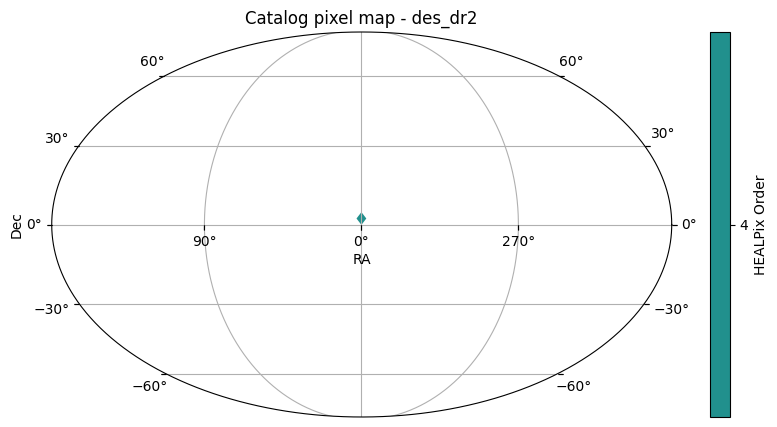

In [8]:
# Read the HATS catalog metadata, it does not load any data, just healpix pixels and other metadata
des_catalog = read_hats(DES_HATS_DIR)
plot_pixels(des_catalog)

This is what you would get for the full catalog, it would have many healpix tiles instead of just a single one. The reason is that `hats-import` splits the data into multiple files to have no more than a million rows per healpix tile / HATS parquet file.

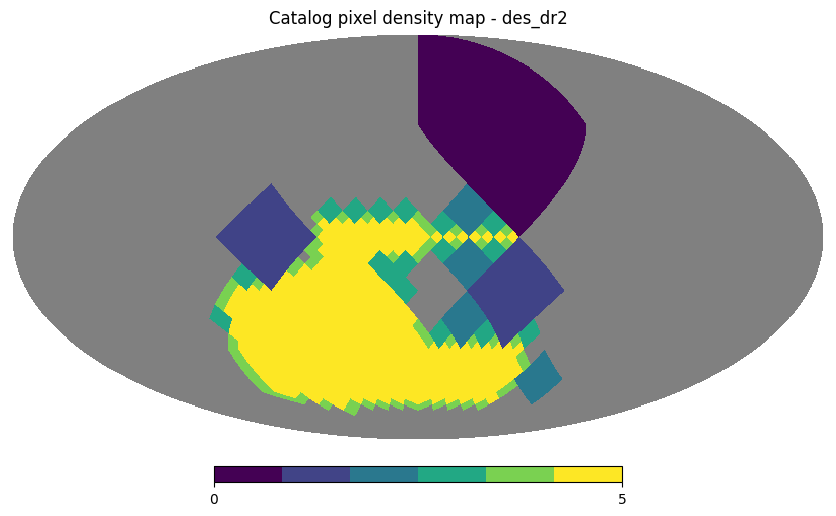

Compare it to the DES DR2 footprint:
![DES DR2 footprint](https://des.ncsa.illinois.edu/static/images/dr2/dr2_footprint.png)

### 4.3. Convert Gaia DR3 to HATS

For Gaia we need to specify schema of the input data, because currently `hats-import` cannot infer column data types properly from this dataset.

See this GitHub issue for more details: <https://github.com/astronomy-commons/hats-import/issues/225>

In [9]:
gaia_file = next(GAIA_DIR.glob("*.csv.gz"))
empty_astropy_table = ascii.read(gaia_file, format="ecsv", data_end=1)
empty_astropy_table.write(
    GAIA_SCHEMA_FILE,
    # Uncomment to overwrite existing schema file
    # overwrite=True,
)

In [10]:
gaia_args = ImportArguments(
    # sort columns are optional and works only if few objects are very close to each other
    sort_columns="source_id",
    ra_column="ra",
    dec_column="dec",
    # We select all Gaia ECSV files skipping the schema file
    input_file_list=list(GAIA_DIR.glob("*.csv.gz")),
    file_reader=CsvReader(
        comment="#",
        schema_file=GAIA_SCHEMA_FILE,
        compression="gzip",
    ),
    use_schema_file=GAIA_SCHEMA_FILE,
    output_artifact_name=GAIA_HATS_NAME,
    output_path=HATS_DIR,
)

pipeline_with_client(gaia_args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/1 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/1 [00:00<?, ?it/s]

Finishing :   0%|          | 0/5 [00:00<?, ?it/s]

### 4.4. Plot the Gaia DR3 HATS catalog pixels

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - gaia_dr3'}>)

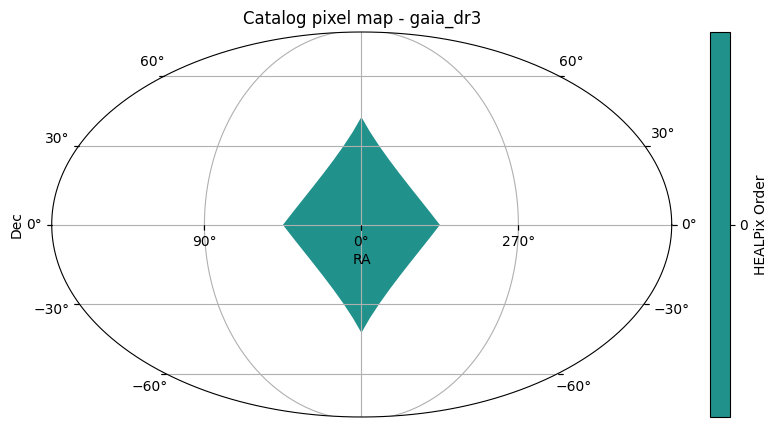

In [11]:
# It should be full sky for the whole catalog
gaia_catalog = read_hats(GAIA_HATS_DIR)
plot_pixels(gaia_catalog)

And this is how it would look like for the entire Gaia catalog.
Notice how Milky Way region is denser and thus has higher healpix order (smaller tiles), since `hats-import` limits the maximum number of objects per pixel to be 1 million.

![Entire Gaia Sky map](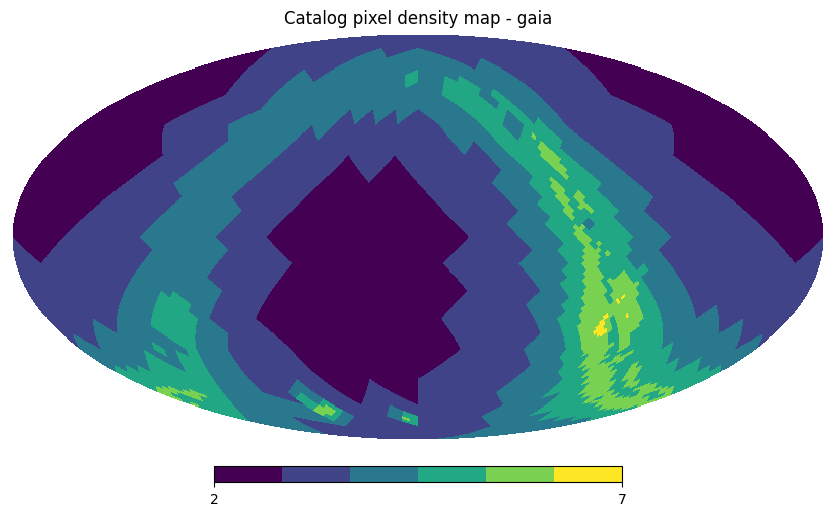
)

### 4.5. Generate margin cache for the Gaia HATS catalog

LSDB requires right-catalog margin cache to generate the complete cross-match result.
Without the margin cache, the objects located near the edges of Healpix tiles may be missed in the cross-match.

In [12]:
margin_cache_args = MarginCacheArguments(
    input_catalog_path=GAIA_HATS_DIR,
    output_path=HATS_DIR,
    margin_threshold=5.0,  # arcsec
    output_artifact_name=GAIA_MARGIN_CACHE_NAME,
)

pipeline_with_client(margin_cache_args, client)

Planning  :   0%|          | 0/3 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/1 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/12 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

## 5. Cross-match the catalogs

The cross-matching in LSDB is not symmetric, meaning the choice of which catalog is "left" and which is "right" is crucial. In our case, we cross-match DES (left) to Gaia (right). This setup generally allows for multiple DES objects to be matched to a single Gaia object, a result of margin caches. Margin caches are designed to prevent missing objects near the edges of Healpix tiles. However, they can lead to multiple matches, where the same Gaia object might match to one DES object in its own tile and another DES object in the neighboring tile that includes this Gaia object in its margin cache.

However, we do not expect it to be a frequent case, because the DES catalog is much deeper than Gaia, and we use a small cross-match radius. 

- Plan the pipeline with LSDB
- Run the pipeline with [Dask](https://dask.org)

In [13]:
des_catalog = lsdb.open_catalog(DES_HATS_DIR)

# gaia_margin_cache_catalog = lsdb.open_catalog(GAIA_MARGIN_CACHE_DIR)
gaia_catalog = lsdb.open_catalog(GAIA_HATS_DIR)

xmatched = des_catalog.crossmatch(
    gaia_catalog,
    # Up to 1 arcsec distance, it is the default
    radius_arcsec=1.0,
    # Single closest object, it is the default
    n_neighbors=1,
    # Default would be to use names of the HATS catalogs
    suffixes=("_des", "_gaia"),
)

display(des_catalog)
display(gaia_catalog)
display(xmatched)

/astro/users/kmalanch/.virtualenvs/default/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:147: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,GALACTIC_L,GALACTIC_B,XWIN_IMAGE,YWIN_IMAGE,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_J2000,ERRTHETA_IMAGE,KRON_RADIUS,EBV_SFD98,MAG_AUTO_G_DERED,MAG_AUTO_R_DERED,MAG_AUTO_I_DERED,MAG_AUTO_Z_DERED,MAG_AUTO_Y_DERED,WAVG_MAG_PSF_G_DERED,WAVG_MAG_PSF_R_DERED,WAVG_MAG_PSF_I_DERED,WAVG_MAG_PSF_Z_DERED,WAVG_MAG_PSF_Y_DERED,EXTENDED_CLASS_COADD,EXTENDED_CLASS_WAVG,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,XWIN_IMAGE_G,XWIN_IMAGE_R,XWIN_IMAGE_I,XWIN_IMAGE_Z,XWIN_IMAGE_Y,YWIN_IMAGE_G,YWIN_IMAGE_R,YWIN_IMAGE_I,YWIN_IMAGE_Z,YWIN_IMAGE_Y,X2WIN_IMAGE_G,X2WIN_IMAGE_R,X2WIN_IMAGE_I,X2WIN_IMAGE_Z,X2WIN_IMAGE_Y,Y2WIN_IMAGE_G,Y2WIN_IMAGE_R,Y2WIN_IMAGE_I,Y2WIN_IMAGE_Z,Y2WIN_IMAGE_Y,XYWIN_IMAGE_G,XYWIN_IMAGE_R,XYWIN_IMAGE_I,XYWIN_IMAGE_Z,XYWIN_IMAGE_Y,ERRX2WIN_IMAGE_G,ERRX2WIN_IMAGE_R,ERRX2WIN_IMAGE_I,ERRX2WIN_IMAGE_Z,ERRX2WIN_IMAGE_Y,ERRY2WIN_IMAGE_G,ERRY2WIN_IMAGE_R,ERRY2WIN_IMAGE_I,ERRY2WIN_IMAGE_Z,ERRY2WIN_IMAGE_Y,ERRXYWIN_IMAGE_G,ERRXYWIN_IMAGE_R,ERRXYWIN_IMAGE_I,ERRXYWIN_IMAGE_Z,ERRXYWIN_IMAGE_Y,AWIN_IMAGE_G,AWIN_IMAGE_R,AWIN_IMAGE_I,AWIN_IMAGE_Z,AWIN_IMAGE_Y,BWIN_IMAGE_G,BWIN_IMAGE_R,BWIN_IMAGE_I,BWIN_IMAGE_Z,BWIN_IMAGE_Y,THETAWIN_IMAGE_G,THETAWIN_IMAGE_R,THETAWIN_IMAGE_I,THETAWIN_IMAGE_Z,THETAWIN_IMAGE_Y,ERRAWIN_IMAGE_G,ERRAWIN_IMAGE_R,ERRAWIN_IMAGE_I,ERRAWIN_IMAGE_Z,ERRAWIN_IMAGE_Y,ERRBWIN_IMAGE_G,ERRBWIN_IMAGE_R,ERRBWIN_IMAGE_I,ERRBWIN_IMAGE_Z,ERRBWIN_IMAGE_Y,ERRTHETAWIN_IMAGE_G,ERRTHETAWIN_IMAGE_R,ERRTHETAWIN_IMAGE_I,ERRTHETAWIN_IMAGE_Z,ERRTHETAWIN_IMAGE_Y,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,FLUX_RADIUS_Z,FLUX_RADIUS_Y,FWHM_IMAGE_G,FWHM_IMAGE_R,FWHM_IMAGE_I,FWHM_IMAGE_Z,FWHM_IMAGE_Y,ISOAREA_IMAGE_G,ISOAREA_IMAGE_R,ISOAREA_IMAGE_I,ISOAREA_IMAGE_Z,ISOAREA_IMAGE_Y,BACKGROUND_G,BACKGROUND_R,BACKGROUND_I,BACKGROUND_Z,BACKGROUND_Y,NITER_MODEL_G,NITER_MODEL_R,NITER_MODEL_I,NITER_MODEL_Z,NITER_MODEL_Y,KRON_RADIUS_G,KRON_RADIUS_R,KRON_RADIUS_I,KRON_RADIUS_Z,KRON_RADIUS_Y,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Z,FLUXERR_AUTO_Y,WAVG_FLUX_PSF_G,WAVG_FLUX_PSF_R,WAVG_FLUX_PSF_I,WAVG_FLUX_PSF_Z,WAVG_FLUX_PSF_Y,WAVG_FLUXERR_PSF_G,WAVG_FLUXERR_PSF_R,WAVG_FLUXERR_PSF_I,WAVG_FLUXERR_PSF_Z,WAVG_FLUXERR_PSF_Y,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_SPREAD_MODEL_G,WAVG_SPREAD_MODEL_R,WAVG_SPREAD_MODEL_I,WAVG_SPREAD_MODEL_Z,WAVG_SPREAD_MODEL_Y,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 4, Pixel: 1216",int64[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int32[py

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 4",int64[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],bool[pyarrow],int16[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

In [14]:
# Run the pipeline with Dask client, it will take a while
xmatched.to_hats(XMATCH_DIR)

In [15]:
# Look into the data
lsdb.open_catalog(XMATCH_DIR).head()

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

### 5.1. Plot the crossmatch points

We will select small "boxes" in the sky to load only small parts of the catalogs and plot them.

Here we do not load the saved cross-matched catalog, but virtually cross-match the catalogs on the fly each time we run `.compute()`.
While it would be more performant to load the cross-matched catalog, the following cell demonstrates that you can work with the cross-matching results without saving them to disk.

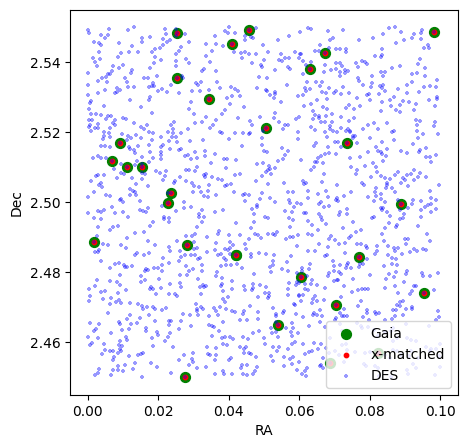

In [16]:
ra_range = [0.0, 0.1]
dec_range = [2.45, 2.55]

des_box = des_catalog.box_search(ra=ra_range, dec=dec_range).compute()
gaia_box = gaia_catalog.box_search(ra=ra_range, dec=dec_range).compute()
xmatch_box = xmatched.box_search(ra=ra_range, dec=dec_range).compute()

ra_des = np.where(des_box["RA"] > 180, des_box["RA"] - 360, des_box["RA"])
ra_gaia = np.where(gaia_box["ra"] > 180, gaia_box["ra"] - 360, gaia_box["ra"])
ra_x_gaia = np.where(xmatch_box["ra_gaia"] > 180, xmatch_box["ra_gaia"] - 360, xmatch_box["ra_gaia"])

plt.figure(figsize=(5, 5))
plt.scatter(ra_gaia, gaia_box["dec"], s=50, alpha=1.0, color="green", label="Gaia")
plt.scatter(ra_x_gaia, xmatch_box["dec_gaia"], s=10, alpha=1.0, color="red", label="x-matched")
plt.scatter(ra_des, des_box["DEC"], s=10, alpha=0.4, marker="+", color="blue", label="DES")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()

### 5.2. Plot the joint HR diagram

Now we may plot the color-magnitude diagram for all the DES stars using Gaia parallaxes. Instead of redoing the cross-match, we will load the saved cross-matched catalog with few columns only.

/astro/users/kmalanch/.virtualenvs/default/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.
  warnings.warn(
/astro/users/kmalanch/.virtualenvs/default/lib/python3.10/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.
  warnings.warn(


Text(0.5, 1.0, 'Absolute magnitude — color diagram')

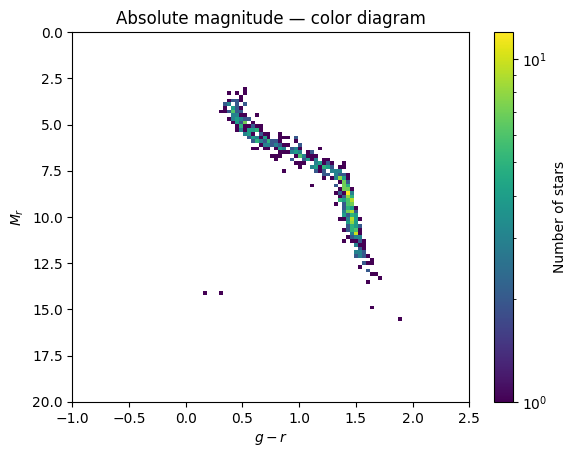

In [17]:
# Read the cross-matched catalog, just like we did before for Gaia and DES,
# but keeping few columns only.
xmatched_from_disk = lsdb.open_catalog(
    XMATCH_DIR,
    columns=[
        "parallax_gaia",
        "parallax_over_error_gaia",
        "WAVG_MAG_PSF_G_des",
        "WAVG_MAG_PSF_R_des",
    ],
)

# Apply quality flags
filtered = xmatched.query(
    "parallax_over_error_gaia > 10.0 and WAVG_MAG_PSF_G_des > 0.0 and WAVG_MAG_PSF_R_des > 0.0"
)

# Get Dask data frame from the catalog object
ddf = filtered._ddf

# get 2D histogram of WAVG_MAG_PSF_R-WAVG_MAG_PSF_I vs WAVG_MAG_PSF_I, lazily
color = ddf["WAVG_MAG_PSF_G_des"] - ddf["WAVG_MAG_PSF_R_des"]
absolute_r = ddf["WAVG_MAG_PSF_R_des"] + 5 * np.log10(ddf["parallax_gaia"] / 100)

x_bins = np.linspace(-1, 2.5, 101)
y_bins = np.linspace(0, 20, 101)

hist2d = dask.array.histogram2d(color.to_dask_array(), absolute_r.to_dask_array(), bins=[x_bins, y_bins])

# Run the computation with Dask client, it will take a while
hist2d = hist2d[0].compute()

# Plot the 2D histogram
plt.imshow(
    hist2d.T,
    extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]),
    aspect="auto",
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.gca().invert_yaxis()
plt.colorbar(label="Number of stars")
plt.xlabel("$g-r$")
plt.ylabel("$M_r$")
plt.title("Absolute magnitude — color diagram")

And this is how it would look like for the entire Gaia + DES cross-matched catalog. This shows ~3.6 million DES stars with Gaia parallaxes left after filtering.

![HR Diagram for the entire catalogs](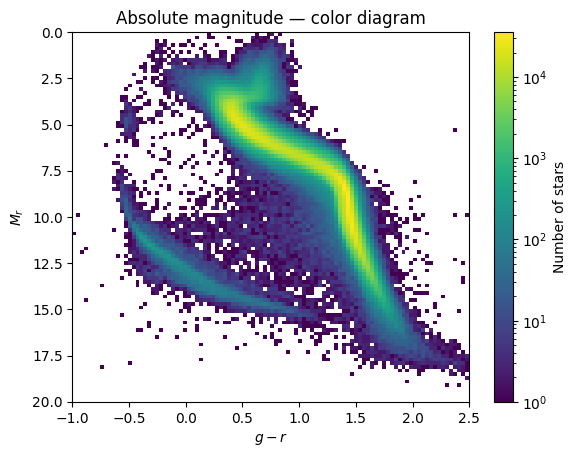
)

In [18]:
client.close()

## About

**Authors**: Konstantin Malanchev

**Last updated on**: June 30, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).